## Notebook to explore core methods

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox

/Users/BlueOwl1/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/BlueOwl1/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


ImportError: dlopen(/Users/BlueOwl1/anaconda/lib/python3.5/site-packages/fiona/ogrext.cpython-35m-darwin.so, 2): Library not loaded: @rpath/libgeos-3.5.0.dylib
  Referenced from: /Users/BlueOwl1/anaconda/lib/libgdal.20.dylib
  Reason: image not found

For this notebook, we will focus on exploring a 10,000 point sample of the 1.1 trillion example dataset.

### Explore raw taxi data

Read in the first 10 rows of the sample dataset to get an idea of what the raw data looks like. The data dictionary for the variables is [here](http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf).

In [2]:
data = pd.read_csv("sample_data/yellow_tripdata_2016-02_sample.csv", nrows=10)
data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-02-25 17:24:20,2016-02-25 17:27:20,2,0.70,-73.947250,40.763771,1,N,-73.992012,40.735390,2,5.0,0.0,0.5,0.00,0,0.3,5.80
1,2,2016-02-25 23:10:50,2016-02-25 23:31:50,2,5.52,-73.983017,40.750992,1,N,-73.988586,40.758839,2,20.0,0.5,0.5,0.00,0,0.3,21.30
2,2,2016-02-01 00:00:01,2016-02-01 00:10:52,6,1.99,-73.992340,40.758202,1,N,-73.964355,40.757977,1,9.5,0.5,0.5,0.70,0,0.3,11.50
3,1,2016-02-01 00:00:04,2016-02-01 00:05:16,1,1.50,-73.981453,40.749722,1,N,-73.982323,40.763985,2,6.5,0.5,0.5,0.00,0,0.3,7.80
4,2,2016-02-01 00:00:05,2016-02-01 00:20:59,1,5.60,-74.000603,40.729755,1,N,-73.951324,40.669834,1,20.0,0.5,0.5,4.00,0,0.3,25.30
5,2,2016-02-01 00:00:06,2016-02-01 00:15:01,1,4.69,-74.005104,40.719006,1,N,-73.947090,40.688885,2,16.0,0.5,0.5,0.00,0,0.3,17.30
6,2,2016-02-01 00:00:09,2016-02-01 00:05:35,1,1.45,-73.986000,40.762146,1,N,-73.990608,40.746208,1,6.5,0.5,0.5,1.56,0,0.3,9.36
7,2,2016-02-01 00:00:19,2016-02-01 00:06:35,1,1.10,-73.966331,40.773422,1,N,-73.956108,40.781422,2,6.5,0.5,0.5,0.00,0,0.3,7.80
8,2,2016-02-01 00:00:21,2016-02-01 00:06:32,1,1.96,-73.976555,40.765697,1,N,-73.978973,40.744381,1,7.5,0.5,0.5,1.00,0,0.3,9.80
9,2,2016-02-01 00:00:21,2016-02-01 00:16:59,2,4.50,-73.976585,40.764931,1,N,-73.911118,40.768909,2,16.0,0.5,0.5,0.00,0,0.3,17.30


Adjust what is read to only include data we might use and to parse dates when the data is being ingested. Read the entire dataset to check for parsing errors and to have the data available for further exploration.

In [3]:
data = pd.read_csv("sample_data/yellow_tripdata_2016-02_sample.csv", 
                   usecols=["tpep_pickup_datetime", 
                            "tpep_dropoff_datetime", 
                            "trip_distance", 
                            "pickup_longitude", 
                            "pickup_latitude", 
                            "dropoff_longitude", 
                            "dropoff_latitude"],
                   parse_dates=["tpep_pickup_datetime", 
                                "tpep_dropoff_datetime"],
                   infer_datetime_format=True)

data.head(10)

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,2016-02-25 17:24:20,2016-02-25 17:27:20,0.70,-73.947250,40.763771,-73.992012,40.735390
1,2016-02-25 23:10:50,2016-02-25 23:31:50,5.52,-73.983017,40.750992,-73.988586,40.758839
2,2016-02-01 00:00:01,2016-02-01 00:10:52,1.99,-73.992340,40.758202,-73.964355,40.757977
3,2016-02-01 00:00:04,2016-02-01 00:05:16,1.50,-73.981453,40.749722,-73.982323,40.763985
4,2016-02-01 00:00:05,2016-02-01 00:20:59,5.60,-74.000603,40.729755,-73.951324,40.669834
5,2016-02-01 00:00:06,2016-02-01 00:15:01,4.69,-74.005104,40.719006,-73.947090,40.688885
6,2016-02-01 00:00:09,2016-02-01 00:05:35,1.45,-73.986000,40.762146,-73.990608,40.746208
7,2016-02-01 00:00:19,2016-02-01 00:06:35,1.10,-73.966331,40.773422,-73.956108,40.781422
8,2016-02-01 00:00:21,2016-02-01 00:06:32,1.96,-73.976555,40.765697,-73.978973,40.744381
9,2016-02-01 00:00:21,2016-02-01 00:16:59,4.50,-73.976585,40.764931,-73.911118,40.768909


#### Time

The pickup and dropoff times are interesting. Let's use these variables to get the number of hours in each trip.

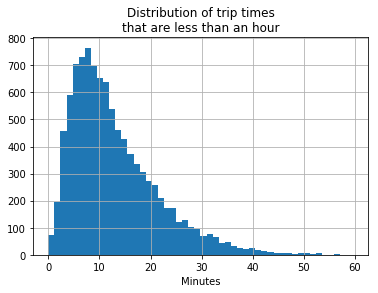

In [4]:
data["trip_time"] = data.tpep_dropoff_datetime - data.tpep_pickup_datetime
data["trip_time_in_hours"] = data.trip_time/np.timedelta64(1, 'h')

# Distribution of trip distance in minutes
(data[data.trip_time_in_hours <= 1].trip_time_in_hours*60).hist(bins=50)
plt.title("Distribution of trip times\nthat are less than an hour")
plt.xlabel("Minutes");

Let's see some basic stats on the data.

In [5]:
data.describe()

,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_time,trip_time_in_hours
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999,9999.000000
mean,2.917597,-72.672719,40.031150,-72.754632,40.077224,0 days 00:15:08.511551,0.252364
std,3.476382,9.728162,5.358700,9.424608,5.191676,0 days 00:54:53.307400,0.914808
min,0.000000,-74.105240,0.000000,-74.392609,0.000000,0 days 00:00:00,0.000000
25%,1.050000,-73.993011,40.733398,-73.992203,40.730145,0 days 00:06:44,0.112222
50%,1.740000,-73.982910,40.750507,-73.981651,40.748932,0 days 00:10:56,0.182222
75%,3.250000,-73.969368,40.764191,-73.961784,40.768612,0 days 00:17:23,0.289722
max,56.900000,0.000000,40.872082,0.000000,41.150688,0 days 23:59:11,23.986389


We can see there are several outliers. We will clean these up and check out the new distribution of the data.

In [6]:
data = data[( (data.trip_distance > 0) 
            & (data.pickup_longitude < 0)
            & (data.pickup_latitude > 40.5)
            & (data.dropoff_longitude < 0)
            & (data.dropoff_longitude > -74.3)
            & (data.dropoff_latitude > 40.5)
            & (data.dropoff_longitude < 0)
            & (data.trip_time_in_hours < 10)
            & (data.trip_time_in_hours > 0.01))]

data.describe()

,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_time,trip_time_in_hours
count,9749.000000,9749.000000,9749.000000,9749.000000,9749.000000,9749,9749.000000
mean,2.922506,-73.975115,40.748519,-73.975796,40.749912,0 days 00:13:06.367627,0.218435
std,3.411741,0.037974,0.026442,0.031006,0.032670,0 days 00:08:52.581678,0.147939
min,0.020000,-74.105240,40.641090,-74.181320,40.567562,0 days 00:00:37,0.010278
25%,1.070000,-73.993271,40.734287,-73.992371,40.731110,0 days 00:06:49,0.113611
50%,1.760000,-73.983383,40.750950,-73.982140,40.749531,0 days 00:10:58,0.182778
75%,3.270000,-73.970833,40.764400,-73.963181,40.769081,0 days 00:17:21,0.289167
max,34.900000,-73.756477,40.872082,-73.484543,40.972141,0 days 03:03:04,3.051111


Looks pretty good. Let's add an average mph feature.

In [7]:
data["average_mph"] = data.trip_distance/data.trip_time_in_hours

data = data[data.average_mph < 75]

Before we decide on the base dataset to use for the analysis going forward, let's explore the data a bit.

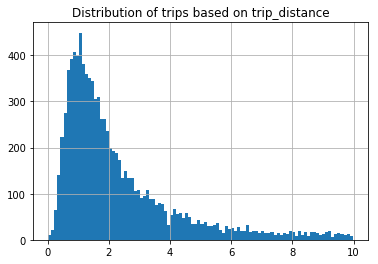

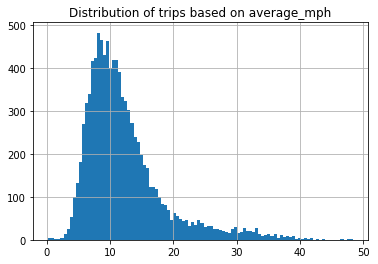

In [8]:
# Make some histograms
var_and_max = [("trip_distance", 10),
               ("average_mph", 100)]

for var, max_val in var_and_max:
    data[data[var] < max_val][var].hist(bins=100)
    plt.title("Distribution of trips based on %s" % var)
    plt.show()

Both charts look reasonable.

Let's take a look at a plot of the pickup locations.

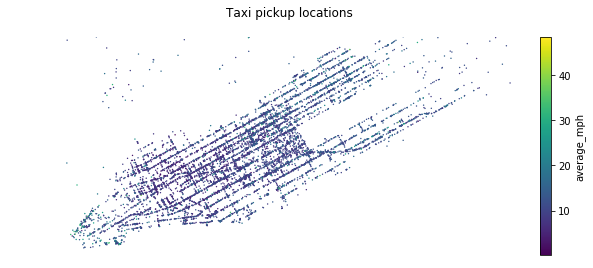

In [9]:
data.plot(kind="scatter", 
               x="pickup_latitude", 
               xlim=(40.7, 40.825),
               y="pickup_longitude", 
               ylim=(-74.02, -73.94),
               c="average_mph",
               linewidths=0,
               s=2,
               colormap="viridis",
               figsize=(10,4))
plt.axis("off")
plt.title("Taxi pickup locations\n");

Very neat. We can see the road networks, see Central Park (based on missing points), see clusters of pickups, and see that the center of Long Island has slower trips on average.

### Shortest distance

In [10]:
import osmnx as ox

ImportError: dlopen(/Users/BlueOwl1/anaconda/envs/OSMNX3/lib/python3.6/site-packages/fiona/ogrext.cpython-36m-darwin.so, 2): Library not loaded: @rpath/libicui18n.56.dylib
  Referenced from: /Users/BlueOwl1/anaconda/envs/OSMNX3/lib/libgdal.20.dylib
  Reason: image not found

### Path to points

### Counter for all intersections